In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import h5py
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, minimize

In [2]:
#data_path = "/Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/radon/5/"
data_path = "/Volumes/GoogleDrive-108630187434314716047/My Drive/yale/uspheres/impulse/radon/radon_in_nipple_6mbar/"
flist = glob(data_path + "Alpha*.h5")

Fs = 125e6/8 ## Hz, decimation factor 8

alpha_dict = {'Po-212': 8784.86, 'Bi-212': 6050.8, 'Rn-220': 6288.1, 'Po-216': 6778.3}

In [3]:
def create_trap_filt(Fs, trise, ttop):
    nrise = int(trise*Fs)
    ntop = int(ttop*Fs)

    rise_vec = np.linspace(0,1,nrise)
    top_vec = np.ones(ntop)

    out_vec = np.hstack( (rise_vec, top_vec, rise_vec[::-1]) )

    if(False):
        plt.plot(out_vec)
    
    return out_vec/np.sum(out_vec)

In [4]:
def trap_filt(y, temp):
    return np.convolve(y, temp, mode='same')

In [5]:
def ffn(x, A, t0, rt=6.56e-07, ft=3.16e-05):
    xx = x-t0
    xx[xx <= 0] = 0
    out_vec = A*np.exp(-xx/ft)*(1-np.exp(-xx/rt))
    out_vec[x < t0] = 0
    return out_vec

In [6]:
def make_template_pulse(flist, npulses, make_plot=False):
    
    fit_vec = np.zeros( (npulses, 4) )
    for i,f in enumerate(flist[:npulses]):

        currf = h5py.File(f, 'r')

        t, v = np.array(currf['time']), np.array(currf['voltage'])

        spars = [-2,4.6e-4,6e-7,3e-5]

        if(make_plot):
            plt.figure()
            plt.plot(t,v)
            plt.plot(t, ffn(t, *spars), 'g')

        bp,_ = curve_fit(ffn, t, v, p0=spars)

        if(make_plot):
            plt.plot(t, ffn(t, *bp), 'r')

        fit_vec[i,:] = bp

    return fit_vec


In [7]:
def make_empirical_template(flist, npulses, make_plot=False):

    tp = 0
    for i,f in enumerate(flist[:npulses]):

        currf = h5py.File(f, 'r')

        t, v = np.array(currf['time']), np.array(currf['voltage'])

        if(np.min(v) > -4):
            continue

        min_loc = np.argmin(v)
        offset = int(len(v)/2 - min_loc) - 900
        tp += np.roll(v,offset)
    
    tp = tp/np.min(tp)

    if(make_plot):
        plt.figure()
        plt.plot(t,tp)
        plt.show()

    return tp


[[-3.82385335e+00  4.76699086e-04  5.09882565e-07  3.22092786e-05]]


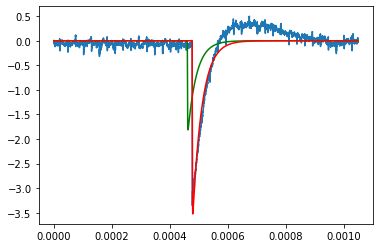

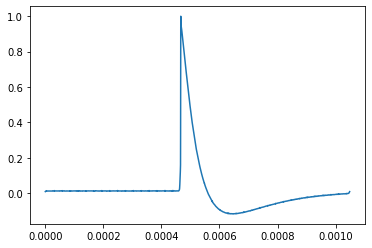

In [8]:
bp = make_template_pulse(flist, 1, make_plot=True)
print(bp)

etemp = make_empirical_template(flist, 5000, make_plot=True)

In [33]:
def emp_ffn(A, y, model, t0):
    chi2 = np.sum( (y - A*np.roll(model,t0))**2 )
    return chi2

SyntaxError: unmatched ')' (1250744166.py, line 2)

5.098825654294452e-07 3.220927858701739e-05


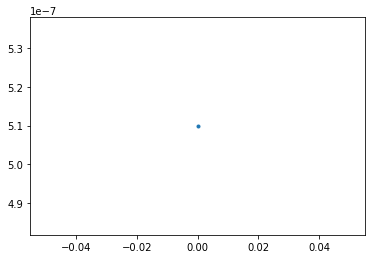

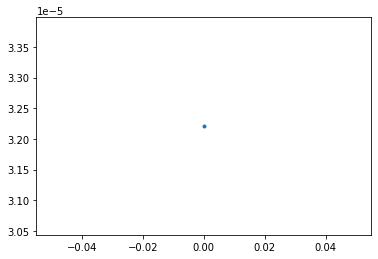

In [10]:


plt.figure()
plt.plot(bp[:,2], '.')

plt.figure()
plt.plot(bp[:,3], '.')

print(np.median(bp[:,2]), np.median(bp[:,3]))

In [11]:
res = minimize(emp_ffn,[-1,0], args=(v,etemp))
print(res)
plt.figure()
plt.plot(v)
plt.plot(-1*np.roll(etemp,0))

NameError: name 'v' is not defined

In [37]:
remake_file = True
do_fit = True

tf = create_trap_filt(Fs, 1e-6, 5e-6)

filt_dat = []

for i,f in enumerate(flist):

    if( i % 1000 == 0): print("Working on file %d"%i)

    currf = h5py.File(f, 'r')

    time = np.asarray(currf['communicate_time'])

    t, v = np.array(currf['time']), np.array(currf['voltage'])

    v -= np.median(v[:1000])

    v_trap_filt = -1 * trap_filt(v, tf) #flip right side up
    s = np.std(v_trap_filt[:2000])
    max_deriv = np.max(np.gradient(v_trap_filt)) #maximum of the derivative to throw out slow pulses

    ## find all the peaks
    peaks, _ = find_peaks(v_trap_filt, height = 10*s, distance=1000)
    for p in peaks:
        ## baseline just before:
        bl = np.median(v_trap_filt[(p-200):(p-100)])

        if(do_fit):
            gpts = (t > t[p-300]) & (t > t[p+500])
            try:
                bp,_ = curve_fit(ffn, t, v, p0=[v_trap_filt[p], t[p]])
                #res = minimize(emp_ffn,-1, args=(v,etemp,bp[1]))
                #bp = res.x
                #chi2 = np.sum( (v[gpts] - ffn(t[gpts], *bp))**2 ) 
                chi2 = np.sum( (v[gpts] - ffn(t[gpts], *bp))**2 ) 
            except:
                bp = [0,0]
                chi2 = -1
        else:
            bp = [0,0]
            chi2 = -1

        ## 0: filtered amplitude, 1: maximum of the derivative, 2: baseline, 3: fit amplitude, 4: fit chi2, 5: file index
        filt_dat.append([v_trap_filt[p], max_deriv, bl, bp[0], chi2, time, i])

        #ispo216 = (bp[0]>-3.65 and bp[0]< -3.6)
        if(False):
            print(chi2, np.polyval([10,-10,35], bp[0]))
            plt.figure(figsize=(6,4))
            plt.plot(t,-v)
            plt.plot(t,v_trap_filt)
            #plt.plot(t, -bp[0]*np.roll(etemp,int(bp[1])))

            #plt.xlim(t[p-300], t[p+500])


if(remake_file):
    np.save("pulse_heights.npy", filt_dat)

Working on file 0
Working on file 1000
Working on file 2000
Working on file 3000
Working on file 4000
Working on file 5000
Working on file 6000


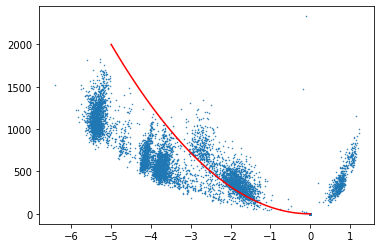

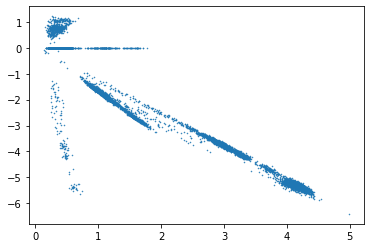

In [38]:
filt_dat = np.load("pulse_heights.npy")
xx = np.linspace(0,-5,100)
plt.plot(filt_dat[:,3], filt_dat[:,4], '.', ms=1)
plt.plot(xx, np.polyval([80,0,0], xx), 'r')
#plt.ylim(0,500)

plt.figure()
plt.plot(filt_dat[:,0], filt_dat[:,3], '.', ms=1)

In [39]:
bins = np.linspace(0, 5, 1500)
gpts = (filt_dat[:,3] < 0) #(filt_dat[:,4] < np.polyval([80,0,0], filt_dat[:,3])) & (filt_dat[:,3] < 0)
h, b = np.histogram(filt_dat[gpts,3], bins=400) #bins)
hfilt, bfilt = np.histogram(filt_dat[gpts,0], bins=400) #bins)
bc = b[:-1] + np.diff(b)/2
bcfilt = bfilt[:-1] + np.diff(bfilt)/2

(0.0, 200.0)

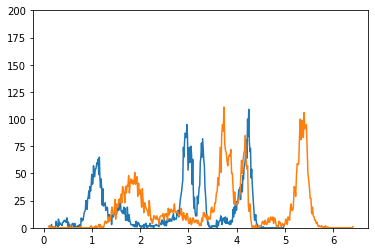

In [43]:
plt.figure()
plt.plot(bcfilt,hfilt)
plt.plot(-bc,h)
plt.ylim(0,200)

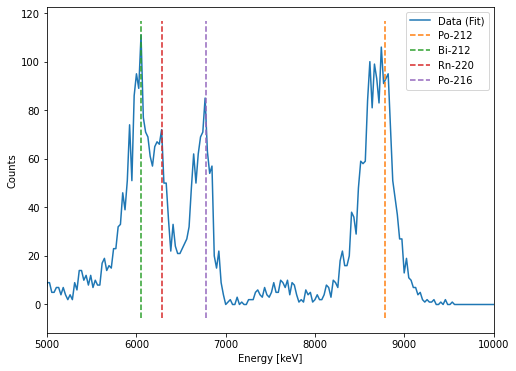

In [47]:
plt.figure(figsize=(8,6))
cal_fac = 6051/bc[np.argmax(h)]
cal_fac_filt = 8785/bcfilt[np.argmax(hfilt)]

cal_dat = filt_dat[:,3] * cal_fac

plt.plot(bc*cal_fac, h, label="Data (Fit)")
#plt.plot(bcfilt*cal_fac_filt, hfilt, label="Data (Trap filt.)")
yy = plt.ylim()
for k in alpha_dict.keys():
    plt.plot(alpha_dict[k]*np.ones(2), yy, '--', label=k)

plt.legend()
plt.xlim(5000,10000)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.show()

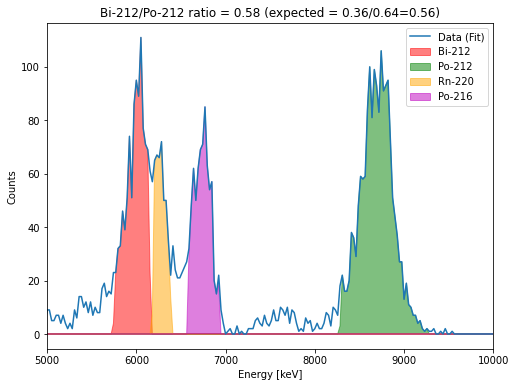

In [50]:
## calculate the Po-212 to Bi-212 ratio

bi212 = (cal_dat > alpha_dict['Bi-212']-300) & (cal_dat < alpha_dict['Bi-212']+100)
h_bi212, b = np.histogram(filt_dat[bi212,3], bins=b)

po212 = (cal_dat > alpha_dict['Po-212']-500) & (cal_dat < alpha_dict['Po-212']+500)
h_po212, b = np.histogram(filt_dat[po212,3], bins=b)

rn220 = (cal_dat > alpha_dict['Rn-220']-100) & (cal_dat < alpha_dict['Rn-220']+100)
h_rn220, b = np.histogram(filt_dat[rn220,3], bins=b)

po216 = (cal_dat > alpha_dict['Po-216']-200) & (cal_dat < alpha_dict['Po-216']+150)
h_po216, b = np.histogram(filt_dat[po216,3], bins=b)

plt.figure(figsize=(8,6))
plt.plot(bc*cal_fac, h, label="Data (Fit)")
plt.fill_between(bc*cal_fac, 0, h_bi212, label="Bi-212", edgecolor=None, color='r', alpha=0.5)
plt.fill_between(bc*cal_fac, 0, h_po212, label="Po-212", edgecolor=None, color='g', alpha=0.5)
plt.fill_between(bc*cal_fac, 0, h_rn220, label="Rn-220", edgecolor=None, color='orange', alpha=0.5)
plt.fill_between(bc*cal_fac, 0, h_po216, label="Po-216", edgecolor=None, color='m', alpha=0.5)

bi_po_ratio = np.sum(bi212)/np.sum(po212)
plt.title("Bi-212/Po-212 ratio = %.2f (expected = 0.36/0.64=0.56)"%bi_po_ratio)
plt.legend()
plt.xlim(5000,10000)
plt.xlabel("Energy [keV]")
plt.ylabel("Counts")
plt.show()



(0.0, 56.0)

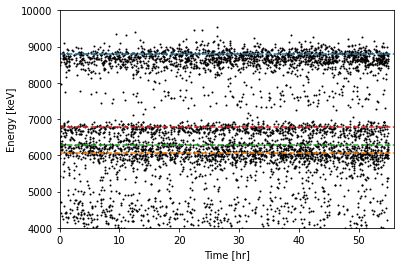

In [93]:
plt.figure()
plt.plot(filt_dat[gpts,5]/3600, cal_dat[gpts], 'k.', ms=2)
plt.ylim(4000,10000)

xx = plt.xlim()
for k in alpha_dict.keys():
    plt.plot(xx,alpha_dict[k]*np.ones(2), '--', label=k)

plt.ylabel("Energy [keV]")
plt.xlabel("Time [hr]")
plt.xlim([0,56])

In [94]:
def exp_fit(t, A, C, tau=10.6*3600/np.ln(2)):
    if(A < 0):
        A = 0
    if(C < 0):
        C = 0
    return A*(1 - np.exp(-t/tau)) + C

AttributeError: module 'numpy' has no attribute 'ln'

[  7200.  21600.  36000.  50400.  64800.  79200.  93600. 108000. 122400.
 136800. 151200. 165600. 180000.]


/usr/local/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


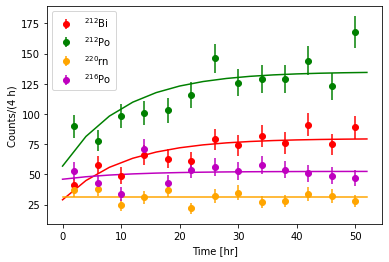

In [95]:
cols = ['r', 'g', 'orange', 'm']
lab = ['$^{212}$Bi', '$^{212}$Po', '$^{220}$rn', '$^{216}$Po']
labels = []
tbins = np.arange(0, filt_dat[-1,5], 4*3600)
tbc = tbins[:-1] + np.diff(tbins)/2

print(tbc)

plt.figure()

for j,cut in enumerate([bi212, po212, rn220, po216]):
    cdat = filt_dat[gpts & cut,5]

    h, b = np.histogram(cdat, bins=tbins)

    spars = [50, 100]
    bp, bc = curve_fit(exp_fit, tbc, h, p0=spars)
    
    #plt.plot(tbc, h, '-', color=cols[j])
    plt.errorbar(tbc/3600, h, yerr=np.sqrt(h), fmt='o', color=cols[j], label=lab[j])
    plt.plot(tbins/3600, exp_fit(tbins, *bp), color=cols[j])

plt.xlabel("Time [hr]")
plt.ylabel('Counts/(4 h)')


plt.legend()
    